In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import pyGadget
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
import seaborn as sns
sns.set_context('poster')
sns.set_style('darkgrid')
sns.despine()
mpl.rc('text', usetex=True)

# Halo Mass Growth History

In [4]:
simname = {'vanilla':r'J = 0',
        'xr_tau_J0': r'J = J$_{0}$', 
        'xr_tau_J1': r'J = 10 J$_{0}$', 
        'xr_tau_J2': r'J = 10$^2$ J$_{0}$',
        'xr_tau_J3': r'J = 10$^3$ J$_{0}$'}
simlist = ['vanilla', 'xr_tau_J0', 'xr_tau_J1', 'xr_tau_J2', 'xr_tau_J3']

In [5]:
store = pd.HDFStore(os.getenv("HOME")+'/data/stampede/mass_history.hdf5')
mg = store['vanilla']
mg0 = store['xr_tau_J0']
mg1 = store['xr_tau_J1']
mg2 = store['xr_tau_J2']
mg3 = store['xr_tau_J3']
store.close()

In [6]:
store = pd.HDFStore(os.getenv("HOME")+'/data/stampede/sinkdata.hdf5')
sinksV = store['vanilla']
sinks0 = store['xr_tau_J0']
sinks1 = store['xr_tau_J1']
sinks2 = store['xr_tau_J2']
sinks3 = store['xr_tau_J3']
store.close()

In [7]:
sinksV.groupby('ID').last().describe()

,time,mass,x,y,z,u,v,w
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,5002.192823,20.464909,2.760877,2.756964,2.722350,-0.356496,-1.664158,2.418367
std,0.000000,10.454960,0.000000,0.000000,0.000001,2.662489,5.608277,4.958286
min,5002.192823,13.072136,2.760877,2.756964,2.722349,-2.239160,-5.629808,-1.087671
25%,5002.192823,16.768523,2.760877,2.756964,2.722350,-1.297828,-3.646983,0.665348
50%,5002.192823,20.464909,2.760877,2.756964,2.722350,-0.356496,-1.664158,2.418367
75%,5002.192823,24.161296,2.760877,2.756964,2.722350,0.584836,0.318668,4.171385
max,5002.192823,27.857682,2.760878,2.756964,2.722351,1.526167,2.301493,5.924404


In [8]:
data = {'vanilla':mg, 'xr_tau_J0':mg0, 'xr_tau_J1':mg1, 'xr_tau_J2':mg2, 'xr_tau_J3':mg3}
sinkdata = {'vanilla':sinksV, 'xr_tau_J0':sinks0, 'xr_tau_J1':sinks1, 'xr_tau_J2':sinks2, 'xr_tau_J3':sinks3}

In [9]:
for sim in data.keys():
    df = data[sim]
    print sim, df[df.time > 0].z.iloc[0]

xr_tau_J3 25.8351433715
xr_tau_J2 25.3220995541
vanilla 25.041431903
xr_tau_J0 25.065217299
xr_tau_J1 25.1496036323


In [10]:
total_mass = {}
for i, sim in enumerate(data.keys()):
    mtot = sinkdata[sim][['time','mass']].groupby('time').sum()
    mtot.rename(columns = {'mass':simname[sim]}, inplace=True)
    total_mass[sim] = mtot.reset_index()

In [11]:
combined = {}
for i, sim in enumerate(simlist):
    df = data[sim]
    sdf = total_mass[sim].rename(columns = {simname[simlist[i]]:'sinks'})
    cdf = pd.merge(df, sdf, on='time')
    cdf['SFE'] = cdf['sinks'] / cdf['100cc']
    cdf["DFE"] = cdf['1e8cc'] / cdf['100cc']
    cdf['AcE'] = cdf['sinks'] / cdf['1e8cc']
    combined[sim] = cdf
#    df['SFE'] = df['100cc'] / 

In [12]:
nkeys = ['10cc', '100cc', '1e4cc', '1e8cc', '1e10cc']
rkeys = ['100pc', '10pc', '1pc', '.1pc', '1e4AU', '5e3AU', '1e3AU']

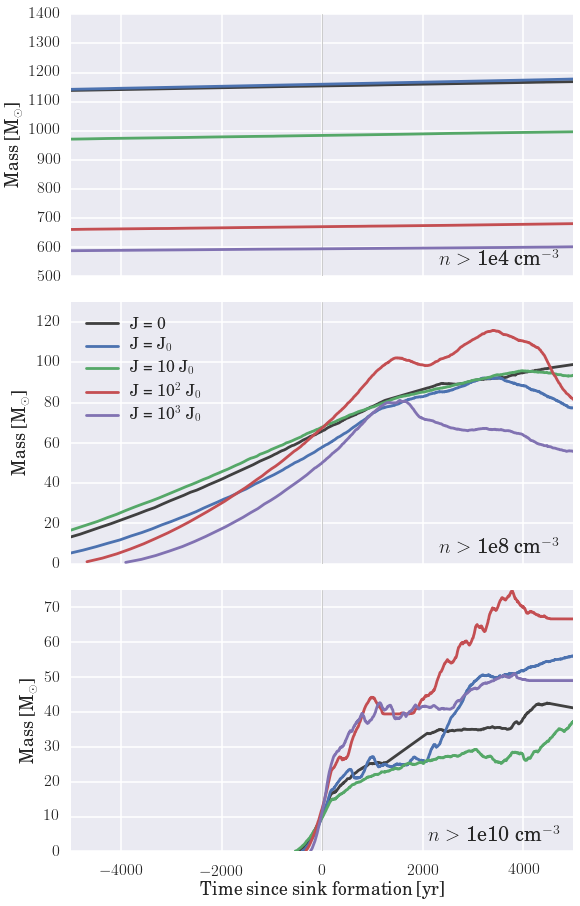

In [13]:
fig, axarr = plt.subplots(3, 1, sharex=True, figsize=(9,15))

for i, dlim in enumerate(nkeys[2:]):
    axarr[i].axvline(0, lw=1, ls='-', c='.8')
    df = mg[mg[dlim] > 0]
    axarr[i].plot(df.time, df[dlim], ls='-', color='.25', label=simname['vanilla'])

    for sim in simlist[1:]:
        df = data[sim]
        df = df[df[dlim] > 0]
        axarr[i].plot(df.time, df[dlim], label=simname[sim])
    axarr[i].set_ylabel('Mass [M$_{\odot}$]')
    axarr[i].set_xlabel("")
    axarr[i].text(.97,.03,"$n >$ "+dlim.replace('cc', ' cm$^{-3}$') , ha='right', va='bottom', 
                  size=20, transform=axarr[i].transAxes)

axarr[0].set_ylim(500, 1.4e3)
axarr[1].set_ylim(0, 130)
axarr[2].set_ylim(0, 75)
axarr[1].legend(loc=0)
axarr[2].set_xlabel("Time since sink formation [yr]")
plt.xlim(-5e3, 5e3)
fig.subplots_adjust(hspace=0.1)
sns.despine()
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

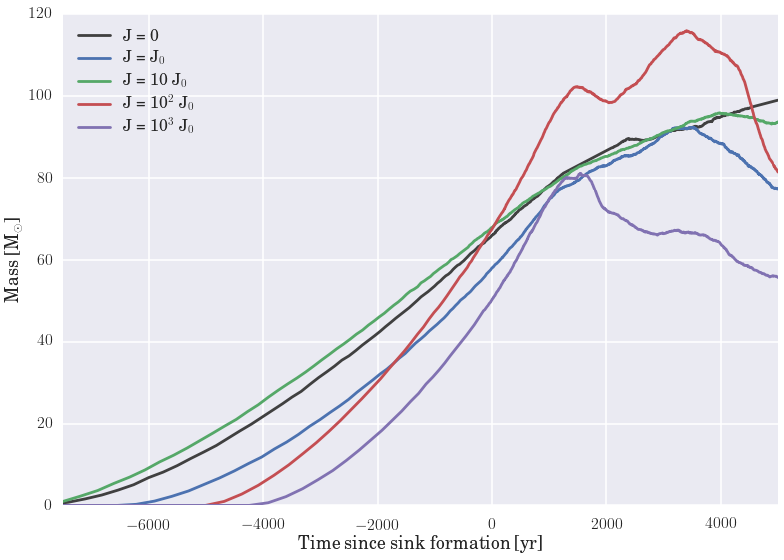

In [14]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    df = data['vanilla']
    df = df[df['1e8cc'] > 0]
    ax.plot(df.time, df['1e8cc'], color='.25', label=simname['vanilla'])
    for sim in simlist[1:]:
        df = data[sim]
        df[df['1e8cc'] > 0]
        ax.plot(df.time, df['1e8cc'], label=simname[sim])
    ax.set_xlim(-7500,5000)
    ax.set_ylim(0,120)
    ax.legend(loc=0)
    ax.set_ylabel('Mass [M$_{\odot}$]')
    ax.set_xlabel("Time since sink formation [yr]")

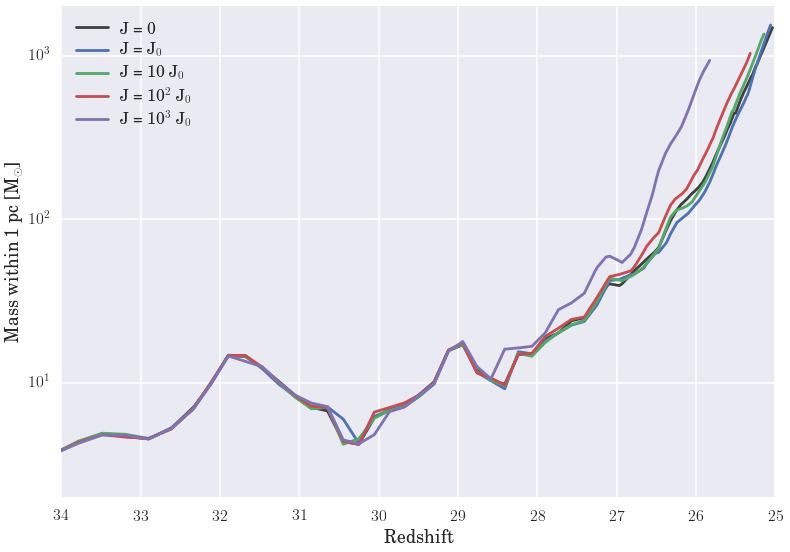

In [15]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    df = data['vanilla']
    df = df[df['1pc'] > 0]
    ax.semilogy(df.z, df['1pc'], color='.25', label=simname['vanilla'])
    for sim in simlist[1:]:
        df = data[sim]
        df = df[df['1pc'] > 0]
        ax.plot(df.z, df['1pc'], label=simname[sim])
    ax.set_xlim(34, 25)
    ax.set_ylim(2,2e3)
    ax.legend(loc=0)
    ax.set_ylabel('Mass within 1 pc [M$_{\odot}$]')
    ax.set_xlabel("Redshift")
fig.savefig('figures/growth/collapse.png', bbox_inches='tight')

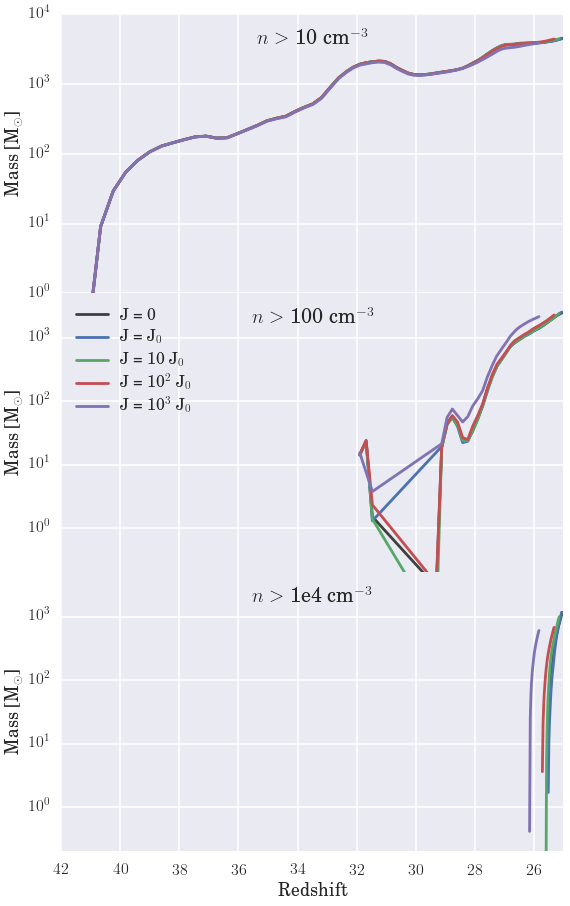

In [16]:
fig, axarr = plt.subplots(3, sharex=True, figsize=(9,15))

for i, dlim in enumerate(nkeys[:3]):
    axarr[i].axvline(0, lw=1, ls='-', c='.8')
    df = mg[mg[dlim] > 0]
    axarr[i].semilogy(df.z, df[dlim], label=simname['vanilla'], ls='-', color='.25')
    for sim in simlist[1:]:
        df = data[sim]
        df= df[df[dlim] > 0]
        axarr[i].plot(df.z, df[dlim], label=simname[sim])
    axarr[i].set_ylabel('Mass [M$_{\odot}$]')
    axarr[i].set_xlabel("")
    axarr[i].text(.5,.95,"$n >$ "+dlim.replace('cc', ' cm$^{-3}$') , ha='center', va='top', 
                  size=20, transform=axarr[i].transAxes)

axarr[0].set_ylim(1, 1e4)
axarr[1].set_ylim(.2, 5e3)
axarr[2].set_ylim(.2, 5e3)
axarr[1].legend(loc=0)
axarr[2].set_xlabel("Redshift")
plt.xlim(42, 25)
fig.subplots_adjust(hspace=0.0)
sns.despine()
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

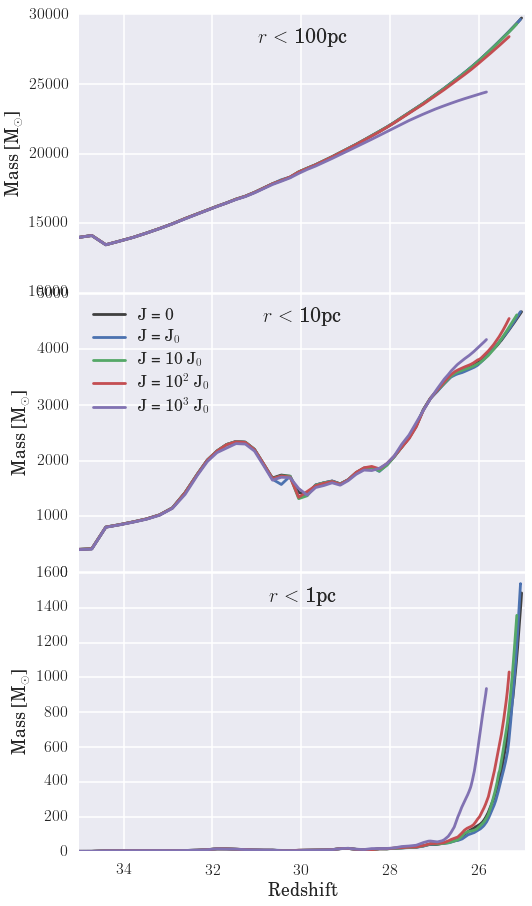

In [17]:
fig, axarr = plt.subplots(3, sharex=True, figsize=(8,15))

for i, dlim in enumerate(rkeys[:3]):
    axarr[i].axvline(0, lw=1, ls='-', c='.8')
    df = mg[mg[dlim] > 0]
    axarr[i].plot(df.z, df[dlim], label=simname['vanilla'], color='.25')

    for sim in simlist[1:]:
        df = data[sim]
        df = df[df[dlim] > 0]
        axarr[i].plot(df.z, df[dlim], label=simname[sim])
    axarr[i].set_ylabel('Mass [M$_{\odot}$]')
    axarr[i].set_xlabel("")
    axarr[i].text(.5,.95,"$r <$ "+dlim, ha='center', va='top', 
                  size=20, transform=axarr[i].transAxes)

#axarr[0].set_ylim(1, 1e4)
#axarr[1].set_ylim(.2, 5e3)
#axarr[2].set_ylim(.2, 5e3)
axarr[1].legend(loc=0)
axarr[2].set_xlabel("Redshift")
plt.xlim(35, 24.95)
fig.subplots_adjust(hspace=0.003)
sns.despine()
fig.savefig('figures/growth/massgrowth_lores.png', bbox_inches='tight')

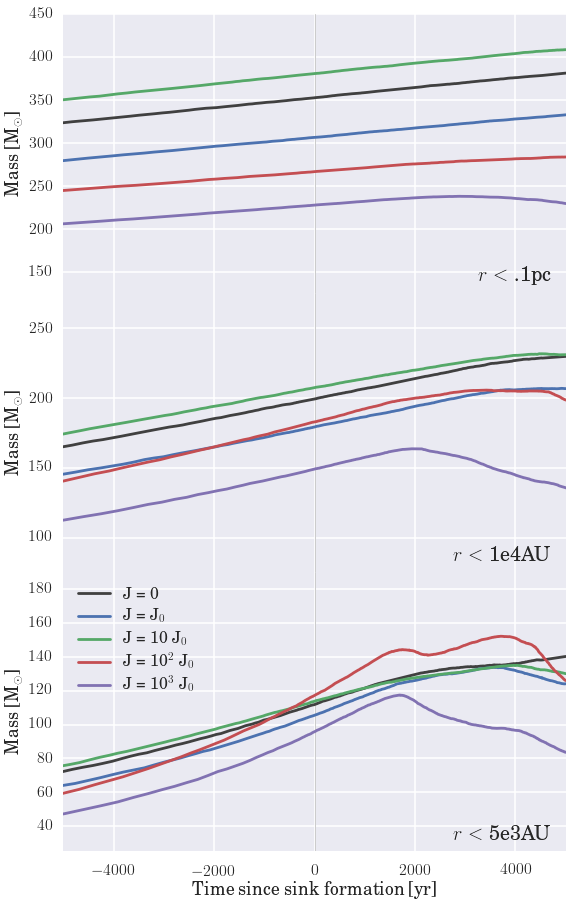

In [18]:
fig, axarr = plt.subplots(3, sharex=True, figsize=(9,15))

for i, dlim in enumerate([rkeys[i] for i in [3,4,5]]):
    axarr[i].axvline(0, lw=1, ls='-', c='.8')
    df = mg[mg[dlim] > 0]
    axarr[i].plot(df.time, df[dlim], label=simname['vanilla'], color='.25')
    for sim in simlist[1:]:
        df = data[sim]
        df = df[df[dlim] > 0]
        axarr[i].plot(df.time, df[dlim], label=simname[sim])
    axarr[i].set_ylabel('Mass [M$_{\odot}$]')
    axarr[i].set_xlabel("")
    axarr[i].text(.97,.03,"$r <$ "+dlim , ha='right', va='bottom', 
                  size=20, transform=axarr[i].transAxes)

axarr[0].set_ylim(125, 450)
axarr[1].set_ylim(75, 275)
axarr[2].set_ylim(25, 190)
axarr[2].legend(loc=0)
axarr[2].set_xlabel("Time since sink formation [yr]")
plt.xlim(-5e3, 5e3)
fig.subplots_adjust(hspace=0.0)
sns.despine()
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

In [19]:
eff_label = {'SFE':"Star Formation Efficiency", 'DFE':"Disk Formation Efficiency", 'AcE':"Sink Accretion Efficiency"}

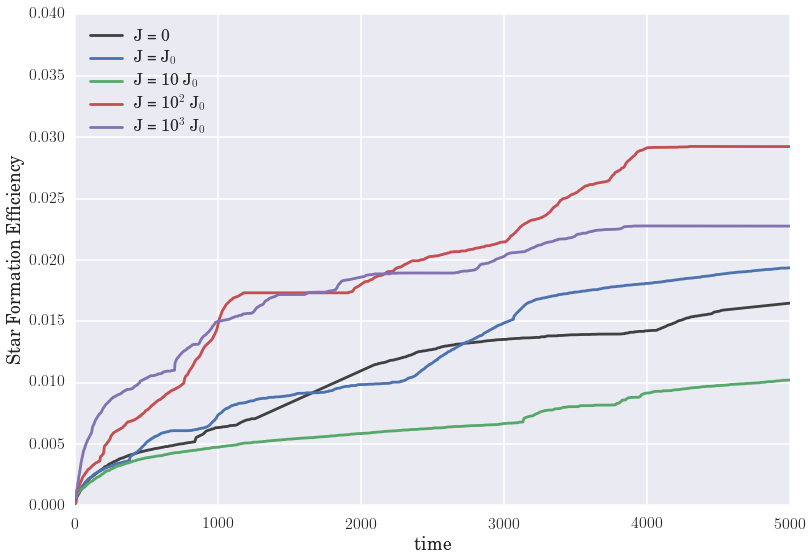

In [20]:
eff = 'SFE'
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    df = combined['vanilla'].set_index('time')
    ax = df[eff].plot(ax=ax, label=simname['vanilla'], ls='-', color='.25')#, grid=False)
    for sim in simlist[1:]:
        df = combined[sim].set_index('time')
        ax = df[eff].plot(ax=ax, label=simname[sim])#, grid=False)
    ax.set_ylabel(eff_label[eff])
    ax.set_xlim(0,5000)
    ax.set_ylim(0,.04)
    ax.legend(loc=2)
#sns.despine()
fig.savefig('figures/growth/efficiency.png', bbox_inches='tight')

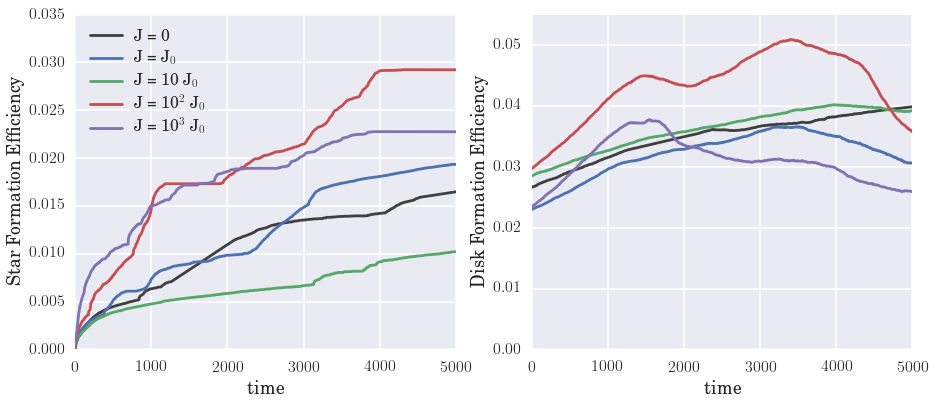

In [21]:
with sns.axes_style("darkgrid"):
    fig, axl = plt.subplots(1,2, sharex=True, figsize=(15,6))
    eff_label = {'SFE':"Star Formation Efficiency", 'DFE':"Disk Formation Efficiency", 'AcE':"Sink Accretion Efficiency"}
    for i, eff in enumerate(['SFE', 'DFE']):
        df = combined['vanilla'].set_index('time')
        axl[i] = df[eff].plot(ax=axl[i], label=simname['vanilla'], ls='-', color='.25')#, grid=False)
        for sim in simlist[1:]:
            df = combined[sim].set_index('time')
            axl[i] = df[eff].plot(ax=axl[i], label=simname[sim])#, grid=False)
        axl[i].set_ylabel(eff_label[eff])
    axl[0].set_xlim(0,5000)
    axl[0].set_ylim(0,.035)
    axl[1].set_ylim(0,0.055)#1.005)
    axl[0].legend(loc=2)
#sns.despine()
fig.savefig('figures/growth/efficiency.png', bbox_inches='tight')

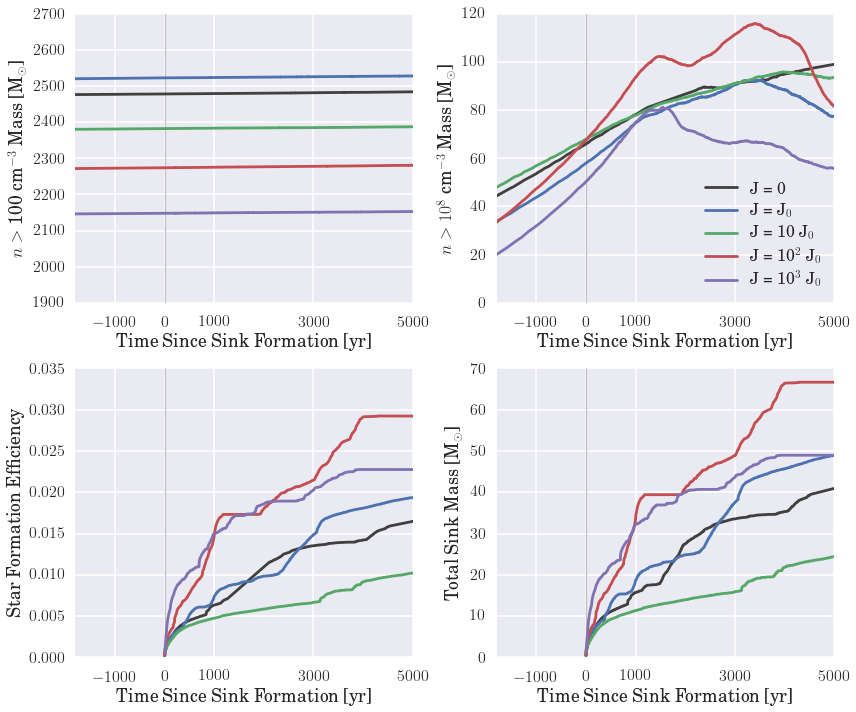

In [22]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(12,10))

for ax in fig.axes:
    ax.axvline(0, lw=1.2, ls='-', c='.75')
    
ax0.plot(mg.time, mg['100cc'], ls='-', color='.25')
ax1.plot(mg.time, mg['1e8cc'], ls='-', color='.25', label=simname['vanilla'])
df = combined['vanilla']
ax2.plot(df.time, df['SFE'], ls='-', color='.25')
df = total_mass['vanilla']
ax3.plot(df.time, df[simname['vanilla']], ls='-', color='.25')

#============ Panel A ==============
for sim in simlist[1:]:
    df = data[sim]
    ax0.plot(df.time, df['100cc'], label=simname[sim])
ax0.set_ylim(1900,2700)
ax0.set_ylabel('$n >$ 100 cm$^{-3}$ Mass [M$_{\odot}$]')

#============ Panel B ==============
for sim in simlist[1:]:
    df = data[sim]
    ax1.plot(df.time, df['1e8cc'], label=simname[sim])
ax1.set_ylim(0,120)
ax1.set_ylabel('$n > 10^8$ cm$^{-3}$ Mass [M$_{\odot}$]')
ax1.legend(loc=0)

#============ Panel C ==============
for sim in simlist[1:]:
    df = combined[sim]
    ax2.plot(df.time, df["SFE"], label=simname[sim])
ax2.set_ylim(0,.035)
ax2.set_ylabel('Star Formation Efficiency')

#============ Panel D ==============
for sim in simlist[1:]:
    df = total_mass[sim]
    ax3.plot(df.time, df[simname[sim]], label=simname[sim])
ax3.set_ylim(0,70)
ax3.set_ylabel('Total Sink Mass [M$_{\odot}$]')


for ax in fig.axes:
    ax.set_xlim(-1.8e3,5e3)
    ax.set_xticks((-1e3, 0, 1e3, 3e3, 5e3))
    ax.set_xlabel('Time Since Sink Formation [yr]')
#fig.subplots_adjust(vspace=1)
fig.tight_layout()
fig.savefig('figures/growth/sinkgrowth.png', bbox_inches='tight')